In [1]:
#pip install optuna

In [2]:
# python --version

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import optuna
import numpy as np
from functools import partial
import pandas as pd
import joblib

optuna.logging.set_verbosity(optuna.logging.WARNING) # removes trial text

# Importing excel sheets as dfs, should both have samples in the same order
predictors_df = pd.read_excel('../Predictors_Cleaned.xlsx', 0)
    # Rows are samples, columns are predictors
outcomes_df = pd.read_excel('../Outcomes_Cleaned.xlsx', 0)
    # Rows are samples, columns are mechanisms

# Dropping unnecessary metadata
X = predictors_df.drop('SAMPLE NAME', axis=1)
Y = outcomes_df.drop('MECHANISM', axis=1) # Full DF must iterate through

columns = list(Y)
# x_train, x_test, y_train, y_test = train_test_split(X, Y['Metronidazole'], random_state=0, shuffle=True, test_size=0.4)

In [17]:
# Graphing function
def graph_r2(r2_list, model_type):
    fig, ax = plt.subplots(figsize=(10,8))
    
    # Sorting r2 values for visualization
    sorted_idx = np.argsort(r2_list)
    r2_array = np.array(r2_list)
    
    # Sorting colors for visualization
    bar_labels = ['Drugs', 'Metals', '_Metals', '_Drugs', '_Drugs', '_Metals', '_Metals', 'Biocides', 'Multi-drug Resistance', '_Biocides', '_Biocides', '_Drugs', '_Drugs', '_Biocides', '_Biocides', '_Drugs', '_Drugs', '_Metals', 'Multi-biocide Resistance', '_Drugs', '_Drugs', '_Drugs', '_Drugs', '_Drugs', 'Drug & Biocide Resistance', 'Multimetal Resistance', '_Metals', '_Drugs', '_Drugs', 'Drug & Biocide & Metal Resistance', '_Drugs', 'Biocide & Metal Resistance', '_Metals', '_Biocides', '_Drugs', '_Biocides', '_Drugs', '_Metals', '_Metals', '_Biocides']
    formatted_genes = ['Lipopeptides', 'Arsenic Resistance', 'Copper Resistance', 'Rifampin',
           'Trimethoprim', 'Tellurim Resistance', 'Zinc Resistance',
           'Peroxide Resistance', 'Multi-drug Resistance', 'Acid Resistance',
           'Phenolic Compound Resistance', 'Mupirocin', 'Nucleosides',
           'Aldehyde Resistance', 'Paraquat Resistance', 'Betalactams',
           'Tetracyclines', 'Nickel Resistance', 'Multibiocide Resistance',
           'Aminoglycoside', 'MLS', 'Fluoroquinolones', 'Fosfomycin',
           'Phenicol Resistance', 'Drug And Biocide Resistance',
           'Multimetal Resistance', 'Mercury Resistance', 'Glycopeptides',
           'Sulfonamides', 'Drug And Biocide And Metal Resistance',
           'Cationic Microbial Peptides', 'Biocide And Metal Resistance',
           'Iron Resistance', 'Bioguanide Resistance', 'Metronidazole',
           'Acetate Resistance', 'Bicitracin', 'Sodium Resistance',
           'Chromium Resistance', 'QACS']
    formatted_genes = np.array(formatted_genes)
    
    drug_color = '#ef476f'
    metal_color = '#99ccff'
    biocide_color = '#83d483'
    multi_drug_color = '#ffd166'
    multi_metal_color = '#f78c6b'
    multi_biocide_color = '#118ab2'
    drug_biocide_color = '#c77dff'
    drug_biocide_metal_color = "#f695ff"
    metal_biocide_color = "#2C2C2C"
    
    bar_colors = [f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{drug_color}', f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{biocide_color}', f'{multi_drug_color}', f'{biocide_color}', f'{biocide_color}', f'{drug_color}', f'{drug_color}', f'{biocide_color}', f'{biocide_color}', f'{drug_color}', f'{drug_color}', f'{metal_color}', f'{multi_biocide_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_biocide_color}', f'{multi_metal_color}', f'{metal_color}', f'{drug_color}', f'{drug_color}', f'{drug_biocide_metal_color}', f'{drug_color}', f'{metal_biocide_color}', f'{metal_color}', f'{biocide_color}', f'{drug_color}', f'{biocide_color}', f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{biocide_color}']
    # [f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{biocide_color}', f'tab:{multi_drug_color}', f'tab:{biocide_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{biocide_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{multi_biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_biocide_color}', f'tab:{multi_metal_color}', f'tab:{metal_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_biocide_metal_color}', f'tab:{drug_color}', f'tab:{metal_biocide_color}', f'tab:{metal_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{biocide_color}']
    
    # Plotting graph
    ax.barh(formatted_genes[sorted_idx], r2_array[sorted_idx], align='center', label=np.array(bar_labels)[sorted_idx], color=np.array(bar_colors)[sorted_idx])
    # ax.barh(np.arange(len(columns)), r2_list, align='center') # old code
    ax.set_yticks(np.arange(len(columns)), labels=formatted_genes[sorted_idx])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('R-Squared')
    ax.set_ylabel('Gene Class')
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_title(f'{model_type} Model Comparison by R-Squared Values using Optuna')
    ax.legend(title='Gene Type')
    
    plt.savefig(f'Graphs/{model_type}_r2_graph.svg', format='svg')
    # plt.show()

In [8]:
# XGBoost Objective function
def xgb_objective(trial, i):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        #'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 0
    }
    test_size = trial.suggest_float('test_size', 0.2, 0.8)

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(X, Y[i], test_size=test_size, random_state=0)

    model = XGBRegressor(**param)  
    model.fit(x_train, y_train)
    
    predict = model.predict(x_test)
    r_2 = abs(r2_score(y_test, predict))

    if r_2 > 1:
        r_2 = 0 # invalid run
    
    return r_2

Lipopeptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.36931294202804565
  Params: 
    max_depth: 4
    learning_rate: 0.26770032631744933
    n_estimators: 312
    gamma: 1.7107292155500027
    test_size: 0.22849941665477222
Arsenic_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3296394348144531
  Params: 
    max_depth: 4
    learning_rate: 0.03905876700923598
    n_estimators: 165
    gamma: 4.8719962859803765
    test_size: 0.6478526554620925
Copper_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9943450689315796
  Params: 
    max_depth: 5
    learning_rate: 0.05288714280193871
    n_estimators: 624
    gamma: 2.553576565075014
    test_size: 0.47094266124229095
Rifampin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.24783170223236084
  Params: 
    max_depth: 7
    learning_rate: 0.049526140328946616
    n_estimators: 882
    gamma: 2.4399185773183545
    test_size: 0.6798870256722915
Trimethoprim


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.5087536573410034
  Params: 
    max_depth: 7
    learning_rate: 0.29851329132786114
    n_estimators: 599
    gamma: 4.925319523569338
    test_size: 0.7686492081007396
Tellurim_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.5524003505706787
  Params: 
    max_depth: 7
    learning_rate: 0.29022030505276375
    n_estimators: 634
    gamma: 2.1120551111533246
    test_size: 0.20120519408120086
Zinc_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.30511581897735596
  Params: 
    max_depth: 4
    learning_rate: 0.10978906488941019
    n_estimators: 757
    gamma: 4.343171199003034
    test_size: 0.7713882796802771
Peroxide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.572704553604126
  Params: 
    max_depth: 7
    learning_rate: 0.11631772763831716
    n_estimators: 901
    gamma: 1.990652572117004
    test_size: 0.5490992749613356
Multi-drug_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.27540671825408936
  Params: 
    max_depth: 6
    learning_rate: 0.16895949298328305
    n_estimators: 148
    gamma: 0.6473444020905833
    test_size: 0.6270124219495656
Acid_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.5315189361572266
  Params: 
    max_depth: 7
    learning_rate: 0.29843774927660016
    n_estimators: 600
    gamma: 3.832931819184856
    test_size: 0.20097761163112393
Phenolic_compound_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9989535808563232
  Params: 
    max_depth: 6
    learning_rate: 0.07395054385139894
    n_estimators: 508
    gamma: 2.918978184417709
    test_size: 0.3027739431231156
Mupirocin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.02500009536743164
  Params: 
    max_depth: 5
    learning_rate: 0.08379192848712926
    n_estimators: 552
    gamma: 3.7285682252033903
    test_size: 0.2007057073096827
Nucleosides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8996074199676514
  Params: 
    max_depth: 5
    learning_rate: 0.196464941666229
    n_estimators: 364
    gamma: 0.8918278185189188
    test_size: 0.7893724925180117
Aldehyde_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3232288360595703
  Params: 
    max_depth: 7
    learning_rate: 0.07326628103546147
    n_estimators: 503
    gamma: 2.9504350138716835
    test_size: 0.7335016585874152
Paraquat_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.19268012046813965
  Params: 
    max_depth: 6
    learning_rate: 0.0513726251438691
    n_estimators: 862
    gamma: 3.562971860430221
    test_size: 0.3552378256400736
Betalactams


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2935723066329956
  Params: 
    max_depth: 7
    learning_rate: 0.11750828951545367
    n_estimators: 622
    gamma: 3.0944215776820903
    test_size: 0.5390527694077452
Tetracyclines


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.416873574256897
  Params: 
    max_depth: 7
    learning_rate: 0.07711991867822086
    n_estimators: 960
    gamma: 1.8845197793195942
    test_size: 0.44876469233625205
Nickel_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.45213210582733154
  Params: 
    max_depth: 5
    learning_rate: 0.08425098612555701
    n_estimators: 753
    gamma: 0.8105077098920808
    test_size: 0.6892155928167403
Multibiocide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2951865792274475
  Params: 
    max_depth: 5
    learning_rate: 0.24395402043590442
    n_estimators: 679
    gamma: 2.6227072901403945
    test_size: 0.6186555813733206
Aminoglycoside


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.6306102275848389
  Params: 
    max_depth: 7
    learning_rate: 0.014390419651773907
    n_estimators: 539
    gamma: 0.9067151868745564
    test_size: 0.7446562225270126
MLS


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3709765672683716
  Params: 
    max_depth: 5
    learning_rate: 0.056967865604888715
    n_estimators: 396
    gamma: 1.8609867043557171
    test_size: 0.5472558605459322
Fluoroquinolones


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3286289572715759
  Params: 
    max_depth: 4
    learning_rate: 0.1502868062801568
    n_estimators: 288
    gamma: 0.6775487557613966
    test_size: 0.24046654354997207
Fosfomycin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.28800177574157715
  Params: 
    max_depth: 7
    learning_rate: 0.033501328034448594
    n_estimators: 903
    gamma: 4.122415249651694
    test_size: 0.7433076849129824
Phenicol_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.38820022344589233
  Params: 
    max_depth: 7
    learning_rate: 0.14178397870246448
    n_estimators: 998
    gamma: 0.6597060010651712
    test_size: 0.5281849310111884
Drug_and_biocide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.5081679821014404
  Params: 
    max_depth: 7
    learning_rate: 0.022980510805375456
    n_estimators: 811
    gamma: 0.2006791965972653
    test_size: 0.7759088113379882
Multimetal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.29787778854370117
  Params: 
    max_depth: 7
    learning_rate: 0.25884535230547795
    n_estimators: 980
    gamma: 2.1004387663550164
    test_size: 0.7996656266301827
Mercury_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9739749431610107
  Params: 
    max_depth: 6
    learning_rate: 0.2056097863784882
    n_estimators: 253
    gamma: 2.919145830292509
    test_size: 0.446151307367565
Glycopeptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.4808279275894165
  Params: 
    max_depth: 7
    learning_rate: 0.0928901357801287
    n_estimators: 148
    gamma: 3.8538511012709415
    test_size: 0.7402448590214928
Sulfonamides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.4732593297958374
  Params: 
    max_depth: 6
    learning_rate: 0.14744843665706098
    n_estimators: 270
    gamma: 3.002128743694585
    test_size: 0.7601715582222278
Drug_and_biocide_and_metal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3898807764053345
  Params: 
    max_depth: 7
    learning_rate: 0.04995128676861468
    n_estimators: 250
    gamma: 2.902494397248712
    test_size: 0.7117589194885462
Cationic_microbial_peptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.6120352745056152
  Params: 
    max_depth: 7
    learning_rate: 0.06375175680403794
    n_estimators: 622
    gamma: 3.572240672434319
    test_size: 0.7388175312222008
Biocide_and_metal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.6629531383514404
  Params: 
    max_depth: 6
    learning_rate: 0.07768019932654383
    n_estimators: 203
    gamma: 2.6624637164505676
    test_size: 0.5173534160626712
Iron_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.930420994758606
  Params: 
    max_depth: 7
    learning_rate: 0.06793730985374347
    n_estimators: 999
    gamma: 0.004736560062790732
    test_size: 0.22769537284586938
Biguanide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9616090059280396
  Params: 
    max_depth: 5
    learning_rate: 0.119781704775929
    n_estimators: 204
    gamma: 0.632949214700128
    test_size: 0.45311436167584845
Metronidazole


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.5032550096511841
  Params: 
    max_depth: 7
    learning_rate: 0.23927811756867678
    n_estimators: 507
    gamma: 0.6620933184153351
    test_size: 0.7617768540300344
Acetate_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9994498491287231
  Params: 
    max_depth: 4
    learning_rate: 0.24791192172124266
    n_estimators: 919
    gamma: 0.31143195886731384
    test_size: 0.6902501846572163
Bacitracin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9870516061782837
  Params: 
    max_depth: 6
    learning_rate: 0.01237240174901405
    n_estimators: 510
    gamma: 0.4162749187725001
    test_size: 0.3632156815893137
Sodium_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9938952922821045
  Params: 
    max_depth: 7
    learning_rate: 0.23408974845729819
    n_estimators: 908
    gamma: 3.9028282255534523
    test_size: 0.42946776484027643
Chromium_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8780544996261597
  Params: 
    max_depth: 7
    learning_rate: 0.1974726430891097
    n_estimators: 838
    gamma: 0.490637189010882
    test_size: 0.7475410451152925
QACS


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9861278533935547
  Params: 
    max_depth: 6
    learning_rate: 0.16010023789289385
    n_estimators: 444
    gamma: 4.536222813764035
    test_size: 0.6170051811714702


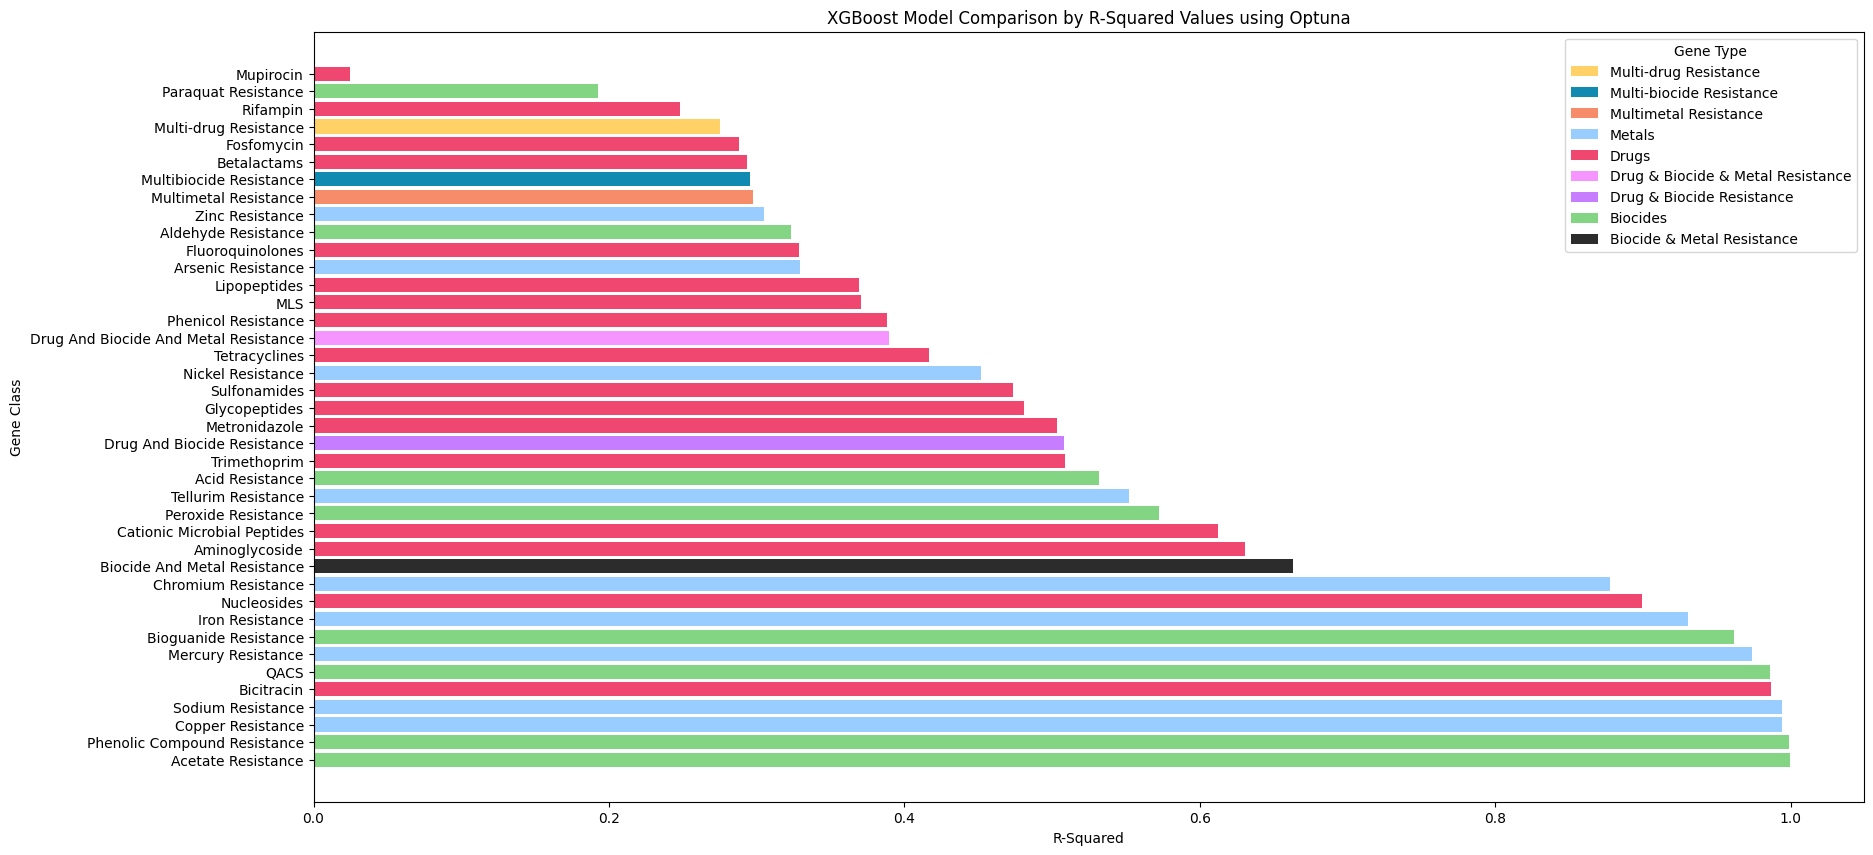

In [9]:
# XGBoost Iterations # https://www.kaggle.com/code/alisultanov/regression-xgboost-optuna
xgb_r2_list = []

for i in columns: # iterate through gene classes
    print(i)
    # Create study
    study = optuna.create_study(direction="maximize") # finding max r_2
    objective = partial(xgb_objective, i = i) # using partial params
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # Print results
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value)) # r2
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Save r2 for visualization
    xgb_r2_list.append(trial.value)
    # Save trial for future usage
    joblib.dump(trial, f"xgbModels/{i}_trial.joblib")

# Graph results
graph_r2(xgb_r2_list, "XGBoost")

In [10]:
# RF Objective Function # https://www.kaggle.com/code/mustafagerme/optimization-of-random-forest-model-using-optuna
def rf_objective(trial, i):
    # Hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    #max_depth = trial.suggest_int("max_depth", 2, 32)
    #min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    #min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    test_size = trial.suggest_float('test_size', 0.2, 0.8)

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(X, Y[i], test_size=test_size, random_state=0)

    # Model random forest
    model = RandomForestRegressor(
    n_estimators=n_estimators,
    #max_depth=max_depth,
    #min_samples_split=min_samples_split,
    #min_samples_leaf=min_samples_leaf,
    random_state=0,
    )
    model.fit(x_train, y_train)

    # Calculate r2
    predict = model.predict(x_test)
    r_2 = abs(r2_score(y_test, predict))

    if r_2 > 1:
        r_2 = 0 # invalid run

    return r_2

Lipopeptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.15540101289946873
  Params: 
    n_estimators: 139
    test_size: 0.7359695518089155
Arsenic_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.338232821057862
  Params: 
    n_estimators: 339
    test_size: 0.215243333545092
Copper_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.7081084248090781
  Params: 
    n_estimators: 470
    test_size: 0.6931563878796769
Rifampin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.16456941017359572
  Params: 
    n_estimators: 108
    test_size: 0.7942729810949594
Trimethoprim


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.24597652646574553
  Params: 
    n_estimators: 211
    test_size: 0.434992182450808
Tellurim_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.1457479966442461
  Params: 
    n_estimators: 791
    test_size: 0.7986412364112775
Zinc_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.369131195033083
  Params: 
    n_estimators: 802
    test_size: 0.20157959368385497
Peroxide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.26952145867430866
  Params: 
    n_estimators: 297
    test_size: 0.3528698057965328
Multi-drug_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.15216608537623988
  Params: 
    n_estimators: 341
    test_size: 0.7974769344336935
Acid_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.18318702312056034
  Params: 
    n_estimators: 503
    test_size: 0.7750048986233459
Phenolic_compound_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.46043334062025276
  Params: 
    n_estimators: 233
    test_size: 0.4024126317654053
Mupirocin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.025000000000000133
  Params: 
    n_estimators: 168
    test_size: 0.20009397578988625
Nucleosides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8552491378315077
  Params: 
    n_estimators: 422
    test_size: 0.24338467104255881
Aldehyde_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.14431459198797691
  Params: 
    n_estimators: 530
    test_size: 0.7982578189116036
Paraquat_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8512251331545411
  Params: 
    n_estimators: 620
    test_size: 0.7813251861629185
Betalactams


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2518809905224043
  Params: 
    n_estimators: 223
    test_size: 0.20227262530515022
Tetracyclines


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.28645517793639075
  Params: 
    n_estimators: 541
    test_size: 0.20096794861575074
Nickel_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2590600939394426
  Params: 
    n_estimators: 393
    test_size: 0.21939388149664235
Multibiocide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2981860697156178
  Params: 
    n_estimators: 223
    test_size: 0.717801676356419
Aminoglycoside


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.23851131235115075
  Params: 
    n_estimators: 100
    test_size: 0.524123459911265
MLS


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.27372814382605126
  Params: 
    n_estimators: 202
    test_size: 0.20060019544440574
Fluoroquinolones


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.18105114357046403
  Params: 
    n_estimators: 546
    test_size: 0.2158895480175621
Fosfomycin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.18441200139067326
  Params: 
    n_estimators: 787
    test_size: 0.20585344557818241
Phenicol_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.25264725073266614
  Params: 
    n_estimators: 301
    test_size: 0.4433652308849256
Drug_and_biocide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3289713186371266
  Params: 
    n_estimators: 305
    test_size: 0.43905077714615964
Multimetal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2895610339908976
  Params: 
    n_estimators: 271
    test_size: 0.2126605651683013
Mercury_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2954074586500828
  Params: 
    n_estimators: 479
    test_size: 0.4054376805350508
Glycopeptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3675791323978673
  Params: 
    n_estimators: 245
    test_size: 0.20221238793848603
Sulfonamides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.24418438895596983
  Params: 
    n_estimators: 208
    test_size: 0.4360598418058637
Drug_and_biocide_and_metal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.23190744085536685
  Params: 
    n_estimators: 914
    test_size: 0.5265495315124193
Cationic_microbial_peptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.43389788855445266
  Params: 
    n_estimators: 201
    test_size: 0.2006764700766805
Biocide_and_metal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.11032268647621857
  Params: 
    n_estimators: 214
    test_size: 0.7227051676737094
Iron_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.07081787920050209
  Params: 
    n_estimators: 938
    test_size: 0.38125722803384443
Biguanide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9816383560176756
  Params: 
    n_estimators: 486
    test_size: 0.7071321279735053
Metronidazole


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.995350245593122
  Params: 
    n_estimators: 586
    test_size: 0.33091191380147933
Acetate_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8141745038155832
  Params: 
    n_estimators: 772
    test_size: 0.6677654143826426
Bacitracin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.6589857067583185
  Params: 
    n_estimators: 592
    test_size: 0.6890312547156797
Sodium_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9850624718719643
  Params: 
    n_estimators: 812
    test_size: 0.20018192167150878
Chromium_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9817159671421805
  Params: 
    n_estimators: 412
    test_size: 0.779036411853227
QACS


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.37260331000207514
  Params: 
    n_estimators: 117
    test_size: 0.6188614785462733


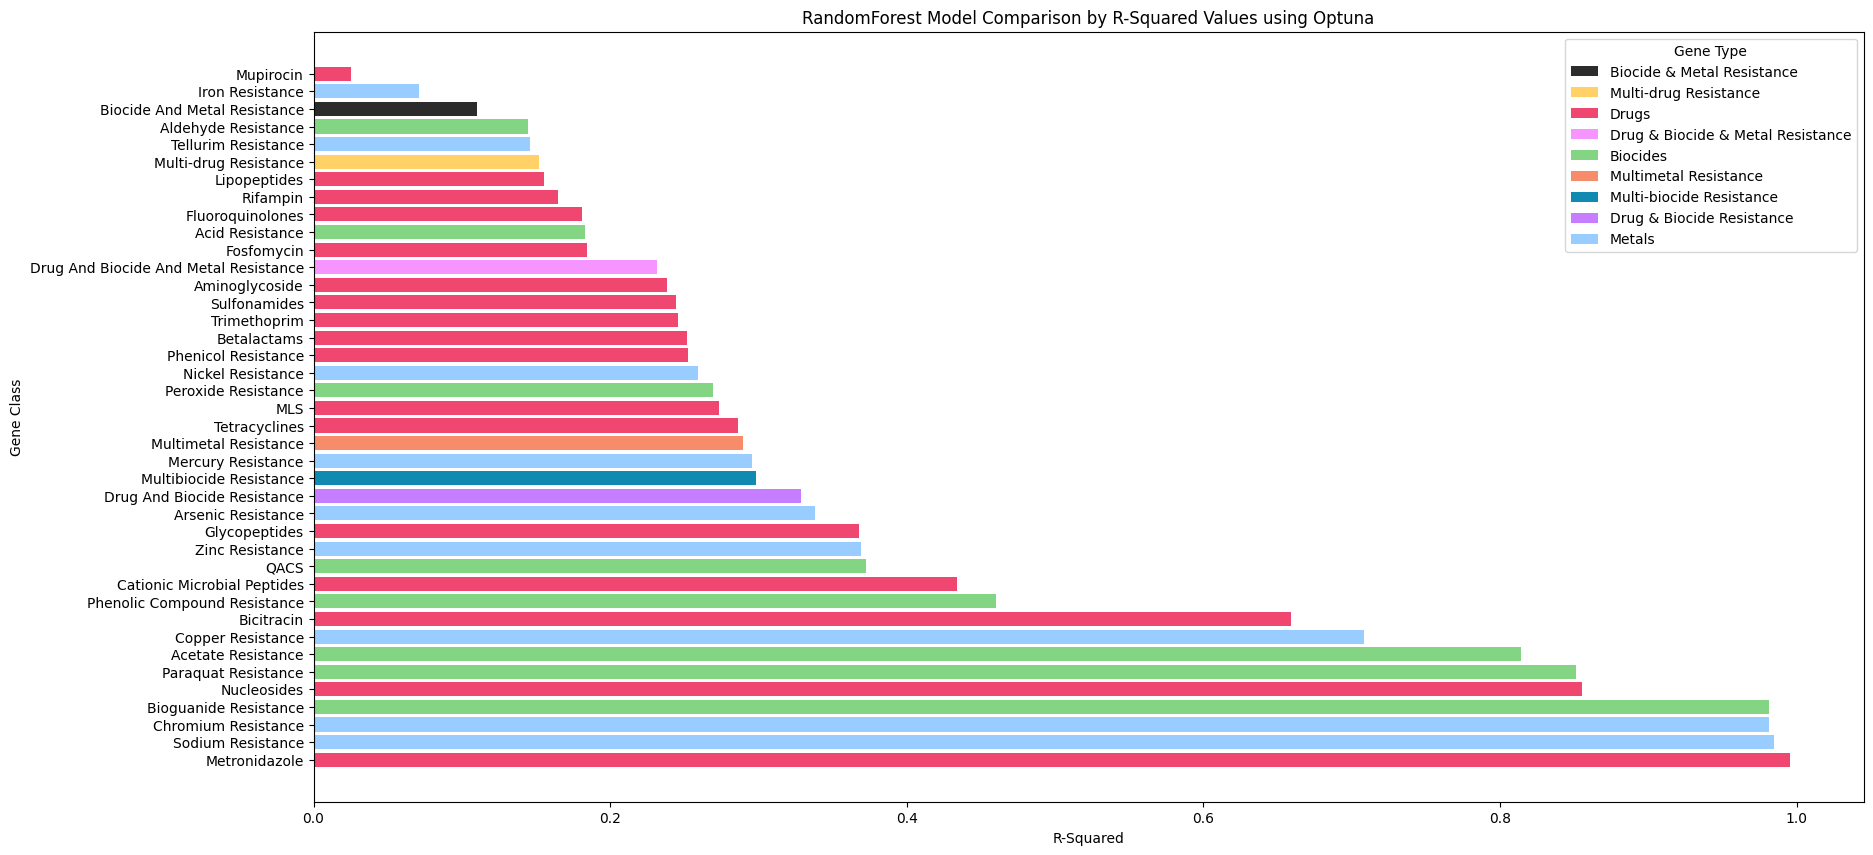

In [11]:
# Random Forest Iterations
rf_r2_list = []

for i in columns: # iterate through gene classes
    print(i)
    # Create study
    study = optuna.create_study(direction="maximize") # finding max r_2
    objective = partial(rf_objective, i = i) # using partial params
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # Print results
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value)) # r2
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Save r2 for visualization
    rf_r2_list.append(trial.value)
    # Save trial for future usage
    joblib.dump(trial, f"rfModels/{i}_trial.joblib")

# Graph results
graph_r2(rf_r2_list, "RandomForest")

In [12]:
# Lasso Objective Function
def lasso_objective(trial, i):
    # Hyperparameters
    alpha = trial.suggest_float("alpha", 0.0001, 0.01)
    max_iter = trial.suggest_int("max_iter", 100000, 10000000)
    test_size = trial.suggest_float('test_size', 0.2, 0.8)

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(X, Y[i], test_size=test_size, random_state=0)
    
    # Model Lasso
    lasso = linear_model.Lasso(alpha=alpha, max_iter=max_iter, random_state=0)
    lasso = lasso.fit(x_train, y_train)

    # Calculating r2
    predict = lasso.predict(x_test)
    r_2 = abs(r2_score(y_test, predict))

    if r_2 > 1:
        r_2 = 0 # invalid run
        
    return r_2

Lipopeptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.5852192109361798
  Params: 
    alpha: 0.003978197761068367
    max_iter: 4937568
    test_size: 0.7400921884963585
Arsenic_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.26166214609871563
  Params: 
    alpha: 0.005795354457793238
    max_iter: 5748113
    test_size: 0.4084339004949762
Copper_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9935452727303287
  Params: 
    alpha: 0.0059998238332524935
    max_iter: 6088230
    test_size: 0.5155735930988969
Rifampin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.44345542360784096
  Params: 
    alpha: 0.003938896477730294
    max_iter: 5994107
    test_size: 0.7201306942008696
Trimethoprim


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3450017753076786
  Params: 
    alpha: 0.006758068130695752
    max_iter: 8754404
    test_size: 0.7175057533137171
Tellurim_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.20484027701092677
  Params: 
    alpha: 0.006075491600872883
    max_iter: 6753600
    test_size: 0.6427606584945225
Zinc_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.39491349299667267
  Params: 
    alpha: 0.0004993140191562027
    max_iter: 8626595
    test_size: 0.7962137866636315
Peroxide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8358273659188511
  Params: 
    alpha: 0.000706242589810584
    max_iter: 810242
    test_size: 0.7205024365074117
Multi-drug_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.4693380654011863
  Params: 
    alpha: 0.0062467910420917015
    max_iter: 3356552
    test_size: 0.7189539112205867
Acid_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.14960233647183663
  Params: 
    alpha: 0.0069700915539918406
    max_iter: 162546
    test_size: 0.6152197267398274
Phenolic_compound_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9411246641536841
  Params: 
    alpha: 0.009408871068232353
    max_iter: 5337112
    test_size: 0.6992616390596333
Mupirocin


  0%|          | 0/50 [00:00<?, ?it/s]

/home/mour/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/mour/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/mour/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+

Best trial:
  Value: 0.025000000000000133
  Params: 
    alpha: 0.005970186128136524
    max_iter: 6449328
    test_size: 0.20088258951639995
Nucleosides


/home/mour/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.7075009626127937
  Params: 
    alpha: 0.00012459903447241925
    max_iter: 5853705
    test_size: 0.7110923426317475
Aldehyde_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.4731908380949008
  Params: 
    alpha: 0.008719761010893768
    max_iter: 1118338
    test_size: 0.7243124432147359
Paraquat_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9122276574388868
  Params: 
    alpha: 0.00020884525613376202
    max_iter: 2684778
    test_size: 0.78311249697151
Betalactams


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2602922846850506
  Params: 
    alpha: 0.00024919502026164156
    max_iter: 7354365
    test_size: 0.719608665456432
Tetracyclines


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.32222329805451566
  Params: 
    alpha: 0.005067930346508442
    max_iter: 181419
    test_size: 0.7182952206434269
Nickel_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.425604427091852
  Params: 
    alpha: 0.002296534074240009
    max_iter: 3024671
    test_size: 0.7371584768604276
Multibiocide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.17054065779505123
  Params: 
    alpha: 0.002487268911995826
    max_iter: 8723334
    test_size: 0.22572812489131977
Aminoglycoside


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.5029919009922237
  Params: 
    alpha: 0.004007445402970721
    max_iter: 9973633
    test_size: 0.7111606219455323
MLS


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.24906721783695307
  Params: 
    alpha: 0.004816042882200298
    max_iter: 6841493
    test_size: 0.7203928273579336
Fluoroquinolones


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.24985456262996864
  Params: 
    alpha: 0.00692434097647592
    max_iter: 3999998
    test_size: 0.7169201859662391
Fosfomycin


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.37370595198969325
  Params: 
    alpha: 0.0011816100639501525
    max_iter: 2930795
    test_size: 0.6190071052541066
Phenicol_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.4405648034878411
  Params: 
    alpha: 0.006512593891720413
    max_iter: 4874228
    test_size: 0.7184085440366136
Drug_and_biocide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.4582933849227837
  Params: 
    alpha: 0.008590374164857941
    max_iter: 8578568
    test_size: 0.7177954648788598
Multimetal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3106698320331769
  Params: 
    alpha: 0.004331265044205279
    max_iter: 9655548
    test_size: 0.6998790773042127
Mercury_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.7831722535711139
  Params: 
    alpha: 0.0064427907541690045
    max_iter: 4261196
    test_size: 0.6078880322469246
Glycopeptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.2940039830345489
  Params: 
    alpha: 0.005542090897833898
    max_iter: 7494743
    test_size: 0.7116006168285316
Sulfonamides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.25461782077014705
  Params: 
    alpha: 0.001366882706675494
    max_iter: 2447451
    test_size: 0.7204086855535761
Drug_and_biocide_and_metal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.5093849257355845
  Params: 
    alpha: 0.005367666133502527
    max_iter: 1455681
    test_size: 0.7217964288456461
Cationic_microbial_peptides


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.3450754972390593
  Params: 
    alpha: 0.005378226228628414
    max_iter: 1118320
    test_size: 0.5057516907953079
Biocide_and_metal_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.13751494780077156
  Params: 
    alpha: 0.009910580984454083
    max_iter: 3947193
    test_size: 0.20062985610348008
Iron_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.07129160769788845
  Params: 
    alpha: 0.004949249011595538
    max_iter: 2996592
    test_size: 0.3719201901235039
Biguanide_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.994519858571455
  Params: 
    alpha: 0.004309346399957223
    max_iter: 4383896
    test_size: 0.6875967502929806
Metronidazole


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8133360883635945
  Params: 
    alpha: 0.0017042523553031526
    max_iter: 7408196
    test_size: 0.4897753723083627
Acetate_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8205903595354243
  Params: 
    alpha: 0.0007255405407088022
    max_iter: 2203706
    test_size: 0.5089624344279194
Bacitracin


  0%|          | 0/50 [00:00<?, ?it/s]

/home/mour/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/mour/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/mour/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+

Best trial:
  Value: 0.9291389851818577
  Params: 
    alpha: 0.0011783871875662173
    max_iter: 8683227
    test_size: 0.6109434864694783
Sodium_resistance


/home/mour/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9875027465266641
  Params: 
    alpha: 0.0021185047238885444
    max_iter: 5914697
    test_size: 0.7522406971158032
Chromium_resistance


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.8163838313613281
  Params: 
    alpha: 0.00064088768977151
    max_iter: 8608678
    test_size: 0.7961520022611429
QACS


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  Value: 0.9928795120155023
  Params: 
    alpha: 0.00998759453326565
    max_iter: 2114870
    test_size: 0.7834157299818482


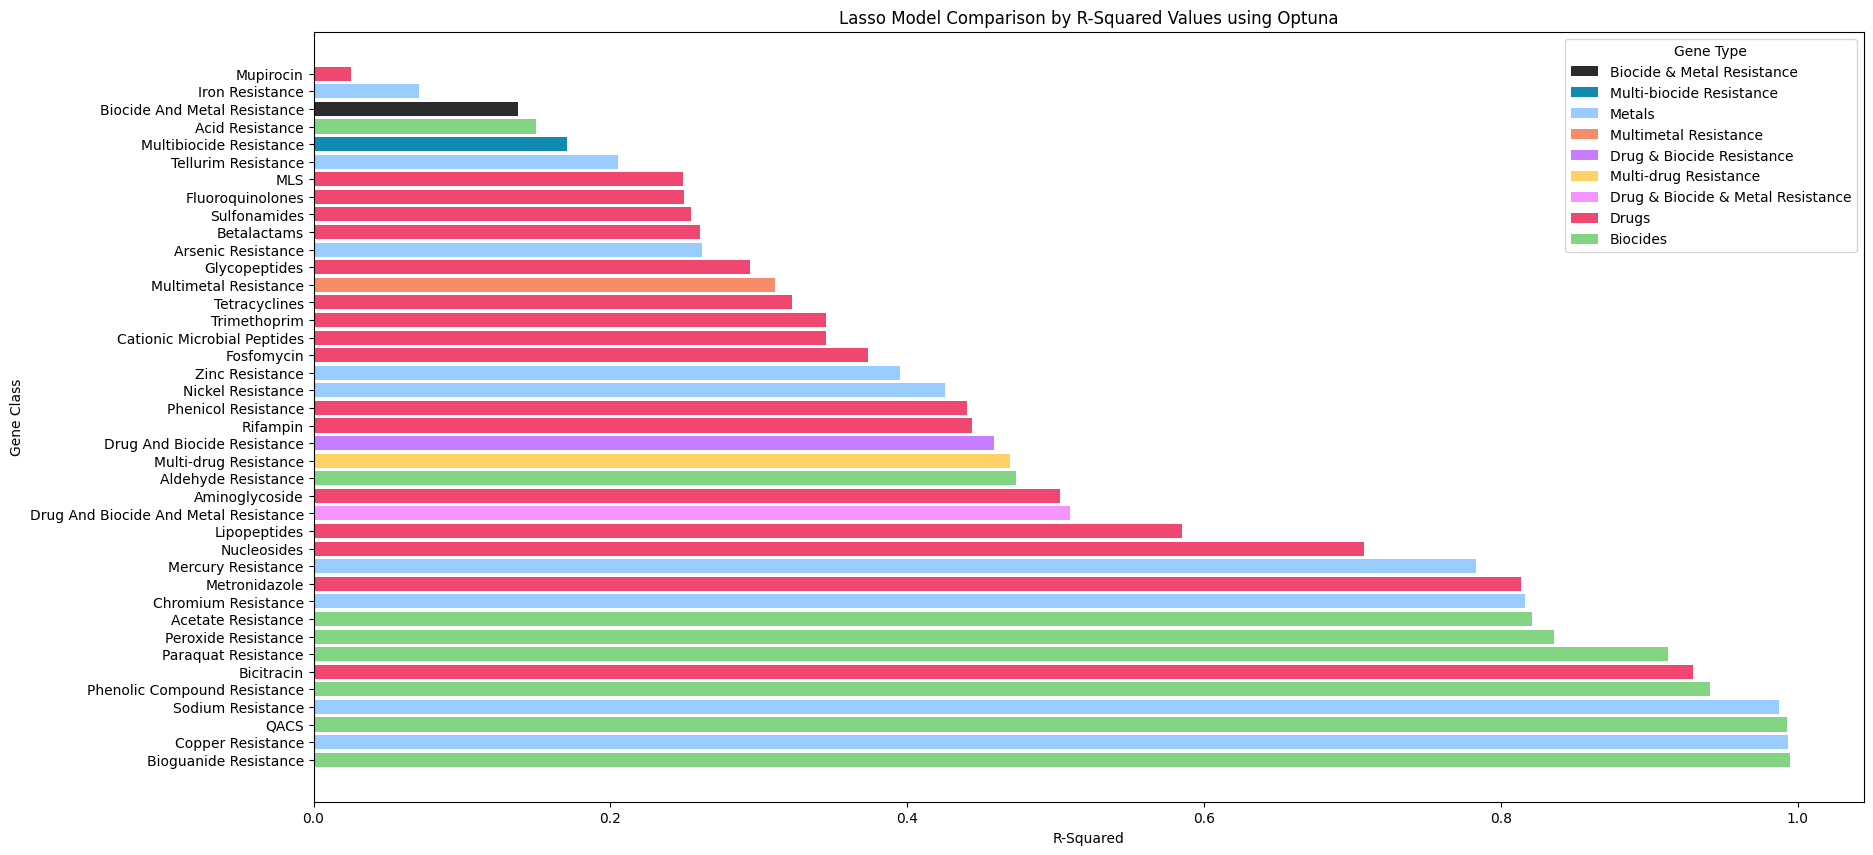

In [13]:
# Lasso Iterations
lasso_r2_list = []

for i in columns: # iterate through gene classes
    print(i)
    # Create study
    study = optuna.create_study(direction="maximize") # finding max r_2
    objective = partial(lasso_objective, i = i) # using partial params
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # Print results
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value)) # r2
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Save r2 for visualization
    lasso_r2_list.append(trial.value)
    # Save trial for future usage
    joblib.dump(trial, f"lassoModels/{i}_trial.joblib")

# Graph results
graph_r2(lasso_r2_list, "Lasso")

In [21]:
# Sorting r2 values to be graphed
graphdict = {}
for i in range(len(lasso_r2_list)):
    methoddict = {"Highest": max(rf_r2_list[i], xgb_r2_list[i], lasso_r2_list[i]), "RandomForest": rf_r2_list[i], "XGBoost": xgb_r2_list[i], "Lasso": lasso_r2_list[i]}
    methoddict = dict(sorted(methoddict.items(), key=lambda item: item[1], reverse=True)) # sort by r2
    graphdict.update({f"{columns[i]}": methoddict})
    
graphdict = dict(sorted(graphdict.items(), key=lambda item: item[1]["Highest"])) # sort by highest r2

for key, value in graphdict.items():
    del value['Highest']

print(graphdict)

{'Mupirocin': {'XGBoost': 0.02500009536743164, 'RandomForest': 0.025000000000000133, 'Lasso': 0.025000000000000133}, 'Betalactams': {'XGBoost': 0.2935723066329956, 'Lasso': 0.2602922846850506, 'RandomForest': 0.2518809905224043}, 'Multibiocide_resistance': {'RandomForest': 0.2981860697156178, 'XGBoost': 0.2951865792274475, 'Lasso': 0.17054065779505123}, 'Multimetal_resistance': {'Lasso': 0.3106698320331769, 'XGBoost': 0.29787778854370117, 'RandomForest': 0.2895610339908976}, 'Fluoroquinolones': {'XGBoost': 0.3286289572715759, 'Lasso': 0.24985456262996864, 'RandomForest': 0.18105114357046403}, 'Arsenic_resistance': {'RandomForest': 0.338232821057862, 'XGBoost': 0.3296394348144531, 'Lasso': 0.26166214609871563}, 'MLS': {'XGBoost': 0.3709765672683716, 'RandomForest': 0.27372814382605126, 'Lasso': 0.24906721783695307}, 'Fosfomycin': {'Lasso': 0.37370595198969325, 'XGBoost': 0.28800177574157715, 'RandomForest': 0.18441200139067326}, 'Zinc_resistance': {'Lasso': 0.39491349299667267, 'RandomF

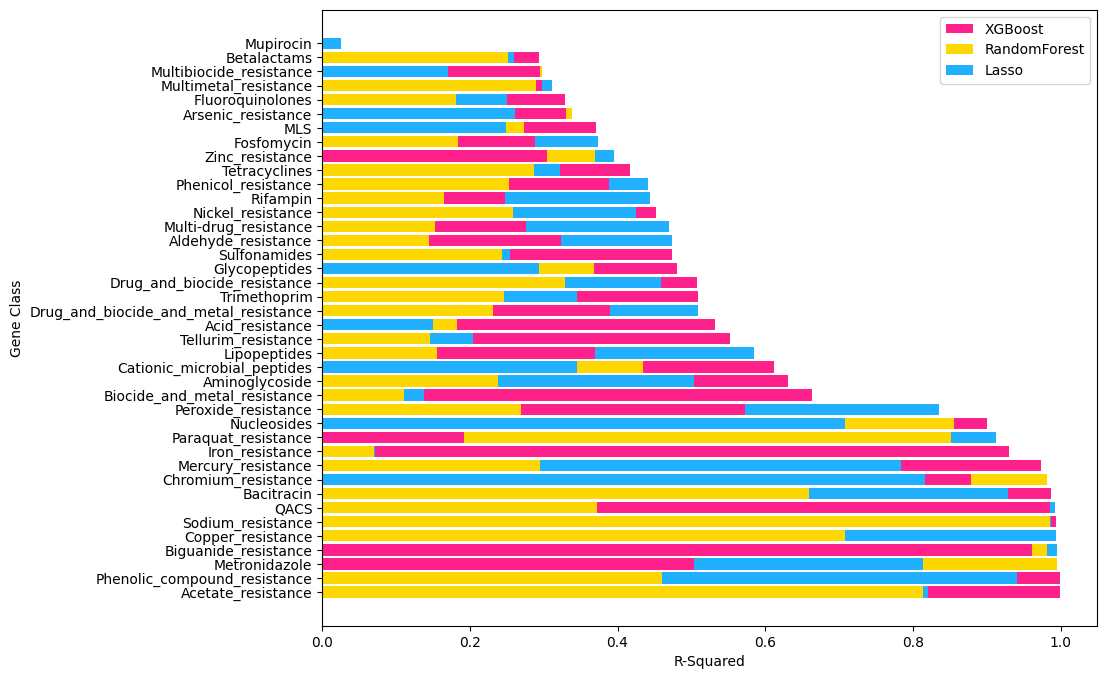

In [22]:
# Graphing Overall Comparision of r2 values for each AMR gene and each mode type
fig, ax = plt.subplots(1, figsize=(10, 8))
colors = {"XGBoost": "#fe218b", "RandomForest": "#fed700", "Lasso": "#21b0fe"}

# stacking bars for each type
for item, (geneClass, methods) in enumerate(graphdict.items()):
    total_r2 = 0
    for value, (method, r2) in enumerate(methods.items()):
        ax.barh(y=item, width=r2, color=colors[method])
        total_r2 += r2

# ticks
ax.set_yticks(range(len(graphdict)))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticklabels([name for name in graphdict], rotation="horizontal")
ax.set_xlabel('R-Squared')
ax.set_ylabel('Gene Class')

# add legend
ax.legend(colors)

plt.savefig(f'stacked_r2_graph.png')
plt.show()

In [2]:
# graphdict = {'Mupirocin': {'XGBoost': 0.02500009536743164, 'RandomForest': 0.025000000000000133, 'Lasso': 0.025000000000000133}, 'Multibiocide_resistance': {'RandomForest': 0.29478001235038176, 'XGBoost': 0.26184868812561035, 'Lasso': 0.24549563000292518}, 'Betalactams': {'XGBoost': 0.29789090156555176, 'Lasso': 0.2495618012871077, 'RandomForest': 0.22112407184926475}, 'Tellurim_resistance': {'Lasso': 0.3220683958161963, 'XGBoost': 0.234794020652771, 'RandomForest': 0.14663968676224148}, 'Fluoroquinolones': {'XGBoost': 0.33513200283050537, 'Lasso': 0.24455888817061533, 'RandomForest': 0.1803581523173059}, 'MLS': {'XGBoost': 0.3615279793739319, 'RandomForest': 0.28401495539040267, 'Lasso': 0.2490421594199721}, 'Arsenic_resistance': {'XGBoost': 0.3638263940811157, 'RandomForest': 0.32413666959958864, 'Lasso': 0.26165262429537894}, 'Multimetal_resistance': {'Lasso': 0.3666010327248115, 'XGBoost': 0.3249855041503906, 'RandomForest': 0.2860423127214712}, 'Fosfomycin': {'Lasso': 0.37807731981202375, 'XGBoost': 0.2847501039505005, 'RandomForest': 0.18747555986911035}, 'Tetracyclines': {'XGBoost': 0.3898424506187439, 'Lasso': 0.32208043474377046, 'RandomForest': 0.28457335104061954}, 'Zinc_resistance': {'Lasso': 0.39484547709143847, 'RandomForest': 0.37916316861908717, 'XGBoost': 0.3043346405029297}, 'Cationic_microbial_peptides': {'RandomForest': 0.4189871783200343, 'Lasso': 0.34666936071931076, 'XGBoost': 0.3387712240219116}, 'Biocide_and_metal_resistance': {'XGBoost': 0.42909276485443115, 'RandomForest': 0.13863264259781216, 'Lasso': 0.13750691908392765}, 'Nickel_resistance': {'Lasso': 0.432441063607093, 'XGBoost': 0.3992149829864502, 'RandomForest': 0.25972099705562035}, 'Phenicol_resistance': {'Lasso': 0.4413055971015647, 'XGBoost': 0.36453866958618164, 'RandomForest': 0.26750604130620725}, 'Rifampin': {'Lasso': 0.44344014191965586, 'XGBoost': 0.2362716794013977, 'RandomForest': 0.15711343957502866}, 'Glycopeptides': {'XGBoost': 0.4498484134674072, 'RandomForest': 0.3752323397175412, 'Lasso': 0.2939993667770082}, 'Multi-drug_resistance': {'Lasso': 0.4699611950465665, 'XGBoost': 0.2397010326385498, 'RandomForest': 0.15559075789077648}, 'Sulfonamides': {'XGBoost': 0.478329062461853, 'Lasso': 0.25454394873601904, 'RandomForest': 0.2440574822875451}, 'Aldehyde_resistance': {'Lasso': 0.4857062894721891, 'XGBoost': 0.32650089263916016, 'RandomForest': 0.14455604841487935}, 'Aminoglycoside': {'Lasso': 0.5029645918441337, 'XGBoost': 0.4493587017059326, 'RandomForest': 0.26632982790157167}, 'Drug_and_biocide_resistance': {'XGBoost': 0.5079230070114136, 'Lasso': 0.458538982786576, 'RandomForest': 0.31963011364883187}, 'Drug_and_biocide_and_metal_resistance': {'Lasso': 0.5187082570823718, 'XGBoost': 0.371578574180603, 'RandomForest': 0.2372889648714409}, 'Trimethoprim': {'XGBoost': 0.5786622762680054, 'Lasso': 0.3453411455564859, 'RandomForest': 0.2419171208476235}, 'Lipopeptides': {'Lasso': 0.5870710289540768, 'XGBoost': 0.2641181945800781, 'RandomForest': 0.15080068222192544}, 'Acid_resistance': {'XGBoost': 0.5949963331222534, 'RandomForest': 0.18404172920907258, 'Lasso': 0.1498663137899281}, 'Peroxide_resistance': {'Lasso': 0.8338485434968181, 'XGBoost': 0.5455077886581421, 'RandomForest': 0.26048293527554045}, 'Mercury_resistance': {'XGBoost': 0.9068901538848877, 'Lasso': 0.7874285519975366, 'RandomForest': 0.29975051718893186}, 'Paraquat_resistance': {'Lasso': 0.9074095909805389, 'RandomForest': 0.8884737317759415, 'XGBoost': 0.7569868564605713}, 'Chromium_resistance': {'RandomForest': 0.9077743457102301, 'Lasso': 0.5790505993510038, 'XGBoost': 0.42799508571624756}, 'Iron_resistance': {'XGBoost': 0.927080512046814, 'Lasso': 0.07236308040948058, 'RandomForest': 0.05452742654111187}, 'Nucleosides': {'XGBoost': 0.9722698926925659, 'RandomForest': 0.9376729503513161, 'Lasso': 0.6995378906557497}, 'Acetate_resistance': {'XGBoost': 0.9867124557495117, 'Lasso': 0.8205288199566003, 'RandomForest': 0.709561206567106}, 'Bacitracin': {'Lasso': 0.9906726627937188, 'XGBoost': 0.9905847311019897, 'RandomForest': 0.6595425218801598}, 'Biguanide_resistance': {'RandomForest': 0.9915167214697391, 'Lasso': 0.9690286856305694, 'XGBoost': 0.8861650228500366}, 'Copper_resistance': {'Lasso': 0.9937743752478714, 'XGBoost': 0.9917693138122559, 'RandomForest': 0.6627293529636054}, 'QACS': {'Lasso': 0.994837501164421, 'XGBoost': 0.9685343503952026, 'RandomForest': 0.3480521248938855}, 'Metronidazole': {'RandomForest': 0.9965134453626212, 'Lasso': 0.808920751602275, 'XGBoost': 0.6613566875457764}, 'Sodium_resistance': {'XGBoost': 0.9994399547576904, 'Lasso': 0.9882588717473189, 'RandomForest': 0.6478017211621125}, 'Phenolic_compound_resistance': {'XGBoost': 0.9995008707046509, 'Lasso': 0.9430408210030417, 'RandomForest': 0.40669505837019515}}

In [ ]:
# CODE DOES NOT WORK
# Receiver Operator Curve 
for i in columns:
    
    best_trial = joblib.load(f"rfModels/{i}_trial.joblib")
    x_train, x_test, y_train, y_test = train_test_split(X, Y[i], test_size=trial.params['test_size'], random_state=0)
    
    model = RandomForestRegressor(n_estimators = trial.params['n_estimators'], random_state = trial.params['random_state'])
    model.fit(x_train, y_train)

    predict = model.predict(x_test)

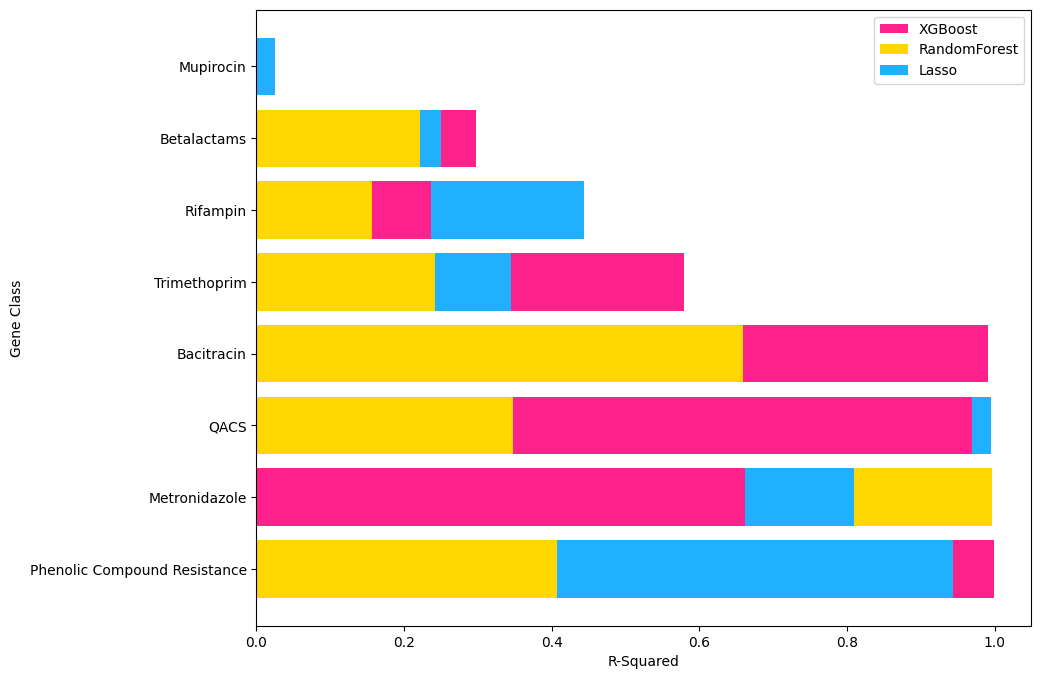

In [23]:
# Subplot Creation for Poster Presentation
fig, ax = plt.subplots(1, figsize=(10, 8))
colors = {"XGBoost": "#fe218b", "RandomForest": "#fed700", "Lasso": "#21b0fe"}
graphdict = {'Mupirocin': {'XGBoost': 0.02500009536743164, 'RandomForest': 0.025000000000000133, 'Lasso': 0.025000000000000133}, 'Betalactams': {'XGBoost': 0.29789090156555176, 'Lasso': 0.2495618012871077, 'RandomForest': 0.22112407184926475}, 'Rifampin': {'Lasso': 0.44344014191965586, 'XGBoost': 0.2362716794013977, 'RandomForest': 0.15711343957502866}, 'Trimethoprim': {'XGBoost': 0.5786622762680054, 'Lasso': 0.3453411455564859, 'RandomForest': 0.2419171208476235}, 'Bacitracin': {'Lasso': 0.9906726627937188, 'XGBoost': 0.9905847311019897, 'RandomForest': 0.6595425218801598}, 'QACS': {'Lasso': 0.994837501164421, 'XGBoost': 0.9685343503952026, 'RandomForest': 0.3480521248938855}, 'Metronidazole': {'RandomForest': 0.9965134453626212, 'Lasso': 0.808920751602275, 'XGBoost': 0.6613566875457764}, 'Phenolic Compound Resistance': {'XGBoost': 0.9995008707046509, 'Lasso': 0.9430408210030417, 'RandomForest': 0.40669505837019515}}
             
# stacking bars for each type
for item, (geneClass, methods) in enumerate(graphdict.items()):
    total_r2 = 0
    for value, (method, r2) in enumerate(methods.items()):
        ax.barh(y=item, width=r2, color=colors[method])
        total_r2 += r2

# ticks
ax.set_yticks(range(len(graphdict)))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticklabels([name for name in graphdict], rotation="horizontal")
ax.set_xlabel('R-Squared')
ax.set_ylabel('Gene Class')

# add legend
ax.legend(colors)

plt.savefig(f'small_r2_graph.svg', format='svg')
plt.show()

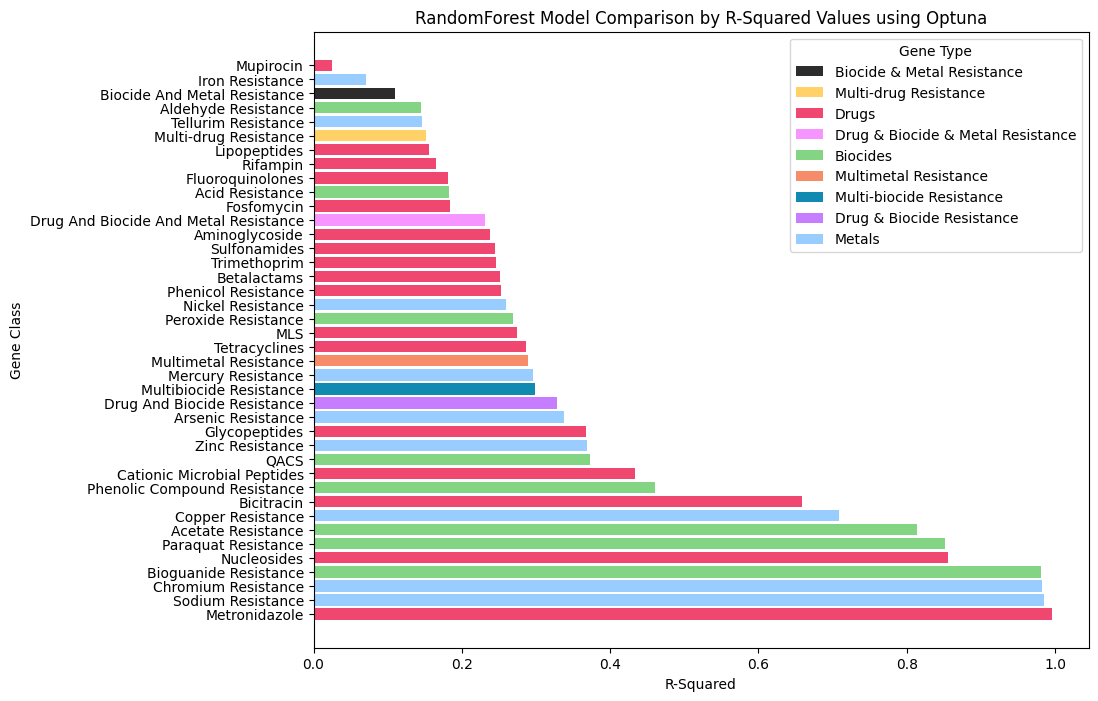

In [19]:
graph_r2(rf_r2_list, "RandomForest")

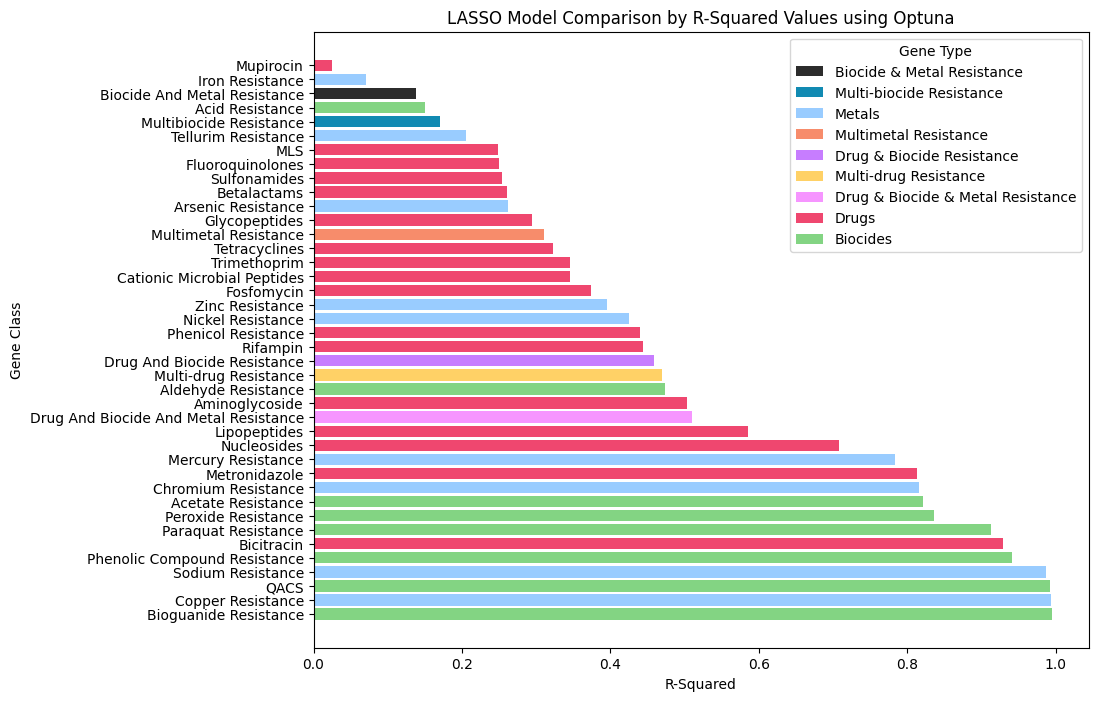

In [20]:
graph_r2(lasso_r2_list, "LASSO")

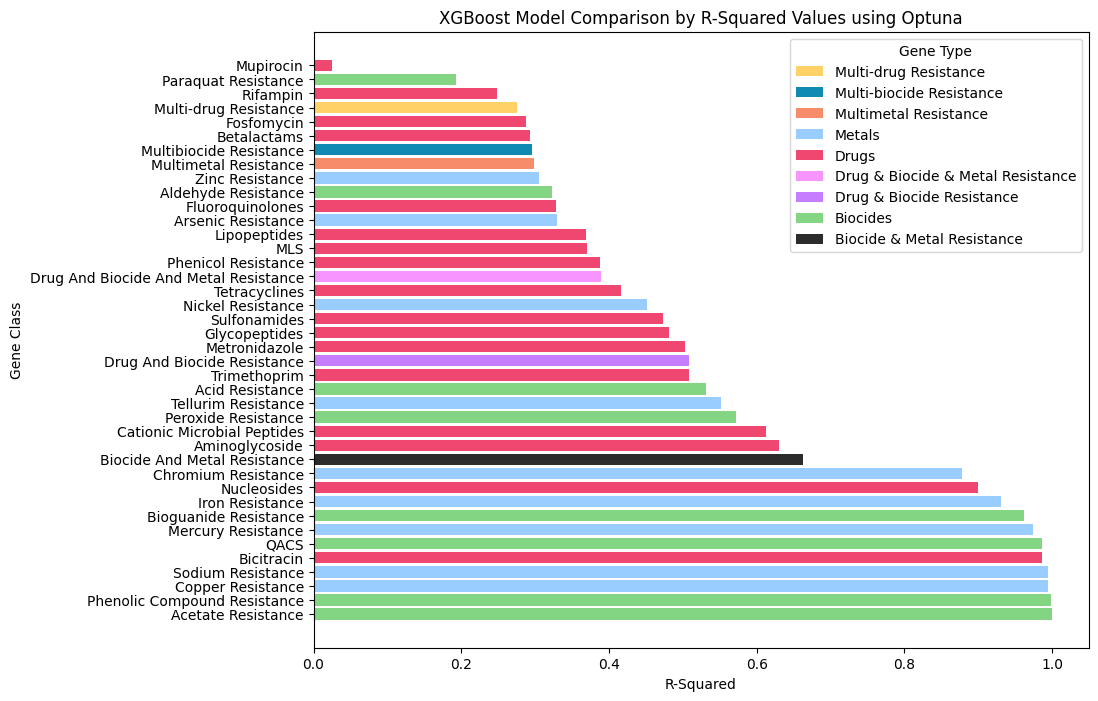

In [18]:
graph_r2(xgb_r2_list, "XGBoost")